<a href="https://colab.research.google.com/github/DRWang3/MPM_testing/blob/main/skeleton_drw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
#@title Model handler class
#from IPython.display import display, HTML
#display(HTML('<h1 style="color: blue; background-color: lightyellow; padding: 10px; border-radius: 5px;">Custom Header</h1>'))

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

class ModelHandler:
    """
    Model Handler class for taking in input files and running the simulation.
    Attributes:
      drivers_filename (str): Path to the drivers CSV file.
      parameter_filename (str): Path to the parameters CSV file.
      resource_pool_filename (str): Path to the resource pool parameters CSV file.
    """
    def __init__(self, drivers_filename, parameter_filename, resource_pool_filename):
        self.drivers_filename = drivers_filename
        self.parameter_filename = parameter_filename
        self.resource_pool_filename = resource_pool_filename


    #Some housekeeping methods below




    def run_simulation(self):
        """
        run_simulation manages the simulation, logging output variables as it loops through each timestep.
        A plant object is instantiated once whereas atmosphere and environment objects are
        instantiated each timestep. Plant does not know about time or space.
        """
        # Runs simulation by looping through each hourly timestep
        drivers, params_dict, resource_pool_params = self.read_input_files()

        # Create a plant object with resource pools
        plant_simulated = Plant(params_dict, resource_pool_params)
        plant_simulated.create_resource_pools()

        self.initialize_logs(plant_simulated)

        for index, row in drivers.iterrows():
            DOY = row['DOY']
            latitude = row['latitude']
            hour = row['Hour']

            # atmosphere object for computing atmospheric properties at this timestep
            atmosphere_instance = Atmosphere(DOY, latitude, hour)
            atmosphere_instance.compute_atmospheric_properties()

            # put together a collective exogenous inputs dict
            exogenous_inputs = atmosphere_instance.get_atmospheric_properties()
            driver_entries = {
              'temperature': row['temperature'],
              'radiation': row['radiation'],
              'precipitation': row['precipitation'],
              'wind_speed': row['wind_speed'],
              'VPD': row['VPD'],
              'latitude': row['latitude']
            }
            exogenous_inputs.update(driver_entries)

            # environment object that acts as interface between plant and non-plant - just aboveground environment for now
            aboveground_environment_instance = AbovegroundEnvironment(exogenous_inputs)
            aboveground_environment_instance.compute_canopy_light_environment(Leaf_Blade_Angle = plant_simulated.get_parameters()['Leaf_Blade_Angle'], Leaf_Area_Index = plant_simulated.get_leaf_area_index())

            # one simulation step of plant
            plant_simulated.simulate_plant(aboveground_environment_instance.get_environmental_variables())

            # update logs
            self.update_logs(plant_simulated)


In [ ]:
#@title Output manager class

class OutputManager:
  """
  description
  """
  def __init__(self, output_filename):
    self.output_filename = output_filename

    def read_input_files(self):
        # Read input CSV files for drivers and parameters
        drivers = pd.read_csv(self.drivers_filename)
        params = pd.read_csv(self.parameter_filename, header=None, usecols=[0, 1])
        params_dict = params.set_index(0).to_dict()[1]
        resource_pool_params = pd.read_csv(self.resource_pool_filename)
        resource_pool_params = resource_pool_params.to_dict(orient='records')
        return drivers, params_dict, resource_pool_params

    def plot_outputs(self):
        # Plot sunlit assimilation in the early part of simulation
        plt.plot(list(range(1500, 1600)), self.log_assimilation[1500:1600], marker='o', linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('assimilation, sunlit (umol CO2 m-2 s-1)')
        plt.grid(True)
        plt.show()

        # Plot sunlit assimilation in the later part of simulation
        plt.plot(list(range(4500, 4600)), self.log_assimilation[4500:4600], marker='o', linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('Assimilation')
        plt.grid(True)
        plt.show()

        # Plot LAI
        plt.plot(list(range(len(self.log_lai))), self.log_lai, linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('leaf area index (m2 m-2)')
        plt.grid(True)
        plt.show()

        # Plot demand for RP1
        plt.plot(list(range(len(self.log_rp_demand))), self.log_rp_demand, linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('RP1 demand (g)')
        plt.grid(True)
        plt.show()

        # Plotting RGR (y-axis)
        plt.plot(list(range(len(self.log_rp_rgr))), self.log_rp_rgr, linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('RP1 relative growth rate (inverse thermal time)')
        plt.grid(True)
        plt.show()

        # Plotting available C
        plt.plot(list(range(len(self.log_carbon_pool))), self.log_carbon_pool, linestyle='-')
        plt.xlabel('timestep')
        plt.ylabel('carbon pool (g)')
        plt.grid(True)
        plt.show()

        # plot multiple RPs
        for name, sizes in self.log_resource_pool_sizes.items():
          plt.plot(sizes, label=name)
        plt.xlabel('timestep')
        plt.ylabel('RP size (g)')
        plt.legend()
        plt.show()

    def initialize_logs(self, plant_instance):
        self.log_thermal_age = []
        self.log_assimilation = []
        self.log_lai = []
        self.log_rp = []
        self.log_rp_demand = []
        self.log_rp_rgr = []
        self.log_carbon_pool = []
        self.log_resource_pool_sizes = {rp.name: [] for rp in plant_instance.get_resource_pools()}

    def update_logs(self, plant_instance):
        self.log_assimilation.append(plant_instance.get_assimilation_sunlit())
        self.log_thermal_age.append(plant_instance.get_thermal_age())
        self.log_lai.append(plant_instance.get_leaf_area_index())
        self.log_rp.append(plant_instance.get_resource_pools()[0].current_size)
        self.log_rp_demand.append(plant_instance.get_resource_pools()[0].demand)
        self.log_rp_rgr.append(plant_instance.get_resource_pools()[0].rgr)
        self.log_carbon_pool.append(plant_instance.get_carbon_pool())
        # update resource pools sizes for any number of resource pools
        for rp in plant_instance.get_resource_pools():
          self.log_resource_pool_sizes[rp.name].append(rp.current_size)

    ## later - method to output file



In [201]:
#@title Atmosphere class
class Atmosphere:
    """This class is aware of time and location and
    uses this to compute atmospheric properties for the simulation.
    """
    def __init__(self, DOY, latitude, hour):
        self.__rad = np.pi / 180
        self.__lat = latitude
        self.__doy = DOY
        self.__hour = hour

    def compute_atmospheric_properties(self):
        #computes atmospheric properties needed for simulating under field conditions

        Sun_Angle_Inclination = -2
        dec = np.arcsin(np.sin(23.45 * self.__rad) * np.cos(2 * np.pi * (self.__doy + 10) / 365))
        Sin_Solar_Declination = np.sin(self.__rad * self.__lat) * np.sin(dec)
        Cos_Solar_Declination = np.cos(self.__rad * self.__lat) * np.cos(dec)
        angle_factor = Sin_Solar_Declination / Cos_Solar_Declination

        Day_Length = 12.0 * (1 + 2 * np.arcsin(angle_factor) / np.pi)
        Photoperiod_Day_Length = 12.0 * (1 + 2 * np.arcsin((-np.sin(Sun_Angle_Inclination * self.__rad) + Sin_Solar_Declination) / Cos_Solar_Declination) / np.pi)
        Daily_Sin_Beam_Exposure = 3600 * (Day_Length * (Sin_Solar_Declination + 0.4 * (Sin_Solar_Declination**2 + Cos_Solar_Declination**2 * 0.5)) +
                             12.0 * Cos_Solar_Declination * (2.0 + 3.0 * 0.4 * Sin_Solar_Declination) * np.sqrt(1.0 - angle_factor**2) / np.pi)
        Solar_Constant = 1367 * (1 + 0.033 * np.cos(2 * np.pi * (self.__doy - 10) / 365))

        hour_angle = (self.__hour - 12) * 15 * self.__rad
        Sin_Beam = max(1e-32, Sin_Solar_Declination * np.sin(hour_angle) + Cos_Solar_Declination * np.cos(hour_angle))

        self.__atmospheric_properties_dict = {
            'Solar_Constant': Solar_Constant,
            'Sin_Solar_Declination': Sin_Solar_Declination,
            'Cos_Solar_Declination': Cos_Solar_Declination,
            'Day_Length': Day_Length,
            'Photoperiod_Day_Length': Photoperiod_Day_Length,
            'Daily_Sin_Beam_Exposure': Daily_Sin_Beam_Exposure,
            'Sin_Beam': Sin_Beam
        }

    def get_atmospheric_properties(self):
        # getter
        return self.__atmospheric_properties_dict


In [202]:
#@title Environment class

class Environment:
    """
    This class represents the interface between plant and non-plant - "a plant jacket"
    """
    def __init__(self, exogenous_inputs):
        self.exogenous_inputs = exogenous_inputs
        self.interface_inputs = {}  # empty to start


In [203]:
#@title Aboveground environment class
class AbovegroundEnvironment(Environment):
    """
    This subclass handles computations in the aboveground plant jacket.
    Currently, these procedures are all related to the canopy light regime.
    """
    def __init__(self, exogenous_inputs):
        super().__init__(exogenous_inputs)  # Call the initializer of the base class
        self.__environmental_variables = self.exogenous_inputs # stores as 'environmental_variables' so interface variables can be added

    #Methods below are associated with the canopy light regime
    def KDR_Coeff(self,Solar_Elev_Sin, Leaf_Blade_Angle):
        Solar_Elev_Angle = np.arcsin(Solar_Elev_Sin)
        if Solar_Elev_Sin >= np.sin(Leaf_Blade_Angle):
            Leaf_Orientation_Avg = Solar_Elev_Sin * np.cos(Leaf_Blade_Angle)
        else:
            Leaf_Orientation_Avg = (2 / np.pi) * (Solar_Elev_Sin * np.cos(Leaf_Blade_Angle) * np.arcsin(np.tan(Solar_Elev_Angle) / np.tan(Leaf_Blade_Angle)) + ((np.sin(Leaf_Blade_Angle))**2 - Solar_Elev_Sin**2)**0.5)

        Direct_Beam_Ext_Coeff = Leaf_Orientation_Avg / Solar_Elev_Sin
        return Direct_Beam_Ext_Coeff

    def KDF_Coeff(self, Leaf_Area_Index, Leaf_Blade_Angle, Scattering_Coeff):
        Beam_Ext_Coeff_15 = self.KDR_Coeff(np.sin(15. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_45 = self.KDR_Coeff(np.sin(45. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_75 = self.KDR_Coeff(np.sin(75. * np.pi / 180.), Leaf_Blade_Angle)

        Diffuse_Ext_Coeff = -1 / Leaf_Area_Index * np.log(0.178 * np.exp(-Beam_Ext_Coeff_15 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.514 * np.exp(-Beam_Ext_Coeff_45 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.308 * np.exp(-Beam_Ext_Coeff_75 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index))
        return Diffuse_Ext_Coeff

    def REFLECTION_Coeff(self,Leaf_Scattering_Coeff, Direct_Beam_Ext_Coeff):
        Scattered_Beam_Ext_Coeff = Direct_Beam_Ext_Coeff * (1 - Leaf_Scattering_Coeff)**0.5
        Horizontal_Leaf_Phase_Function = (1 - (1 - Leaf_Scattering_Coeff)**0.5) / (1 + (1 - Leaf_Scattering_Coeff)**0.5)
        Canopy_Beam_Reflect_Coeff = 1 - np.exp(-2 * Horizontal_Leaf_Phase_Function * Direct_Beam_Ext_Coeff / (1 + Direct_Beam_Ext_Coeff))
        return Scattered_Beam_Ext_Coeff, Canopy_Beam_Reflect_Coeff

    def LIGHT_ABSORB(self,Scattering_Coeff, Direct_Beam_Ext_Coeff, Scattered_Beam_Ext_Coeff, Diffuse_Ext_Coeff, Canopy_Beam_Reflect_Coeff, Canopy_Diffuse_Reflect_Coeff, Incident_Direct_Beam_Rad, Incident_Diffuse_Rad, Leaf_Area_Index):
        Total_Canopy_Absorbed_Light = (1. - Canopy_Beam_Reflect_Coeff) * Incident_Direct_Beam_Rad * (1. - np.exp(-Scattered_Beam_Ext_Coeff * Leaf_Area_Index)) + (1. - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad * (1. - np.exp(-Diffuse_Ext_Coeff * Leaf_Area_Index))

        Absorbed_Sunlit_Rad = (1 - Scattering_Coeff) * Incident_Direct_Beam_Rad * (1 - np.exp(-Direct_Beam_Ext_Coeff * Leaf_Area_Index)) \
            + (1 - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad / (Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Diffuse_Ext_Coeff * (1 - np.exp(-(Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
            + Incident_Direct_Beam_Rad * ((1 - Canopy_Beam_Reflect_Coeff) / (Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Scattered_Beam_Ext_Coeff * (1 - np.exp(-(Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
                                          - (1 - Scattering_Coeff) * (1 - np.exp(-2 * Direct_Beam_Ext_Coeff * Leaf_Area_Index)) / 2)

        Absorbed_Shaded_Rad = Total_Canopy_Absorbed_Light - Absorbed_Sunlit_Rad
        return Absorbed_Sunlit_Rad, Absorbed_Shaded_Rad

    def compute_canopy_light_environment(self, Leaf_Blade_Angle, Leaf_Area_Index):
        # constants needed for computation
        Scattering_Coefficient_PAR = 0.2  # Leaf scattering coefficient for PAR
        Canopy_Diffuse_Reflection_Coefficient_PAR = 0.057  # Canopy diffuse PAR reflection coefficient

        Incoming_PAR = 0.5 * self.exogenous_inputs['radiation']
        Atmospheric_Transmissivity = Incoming_PAR / (0.5 * self.exogenous_inputs['Solar_Constant'] * self.exogenous_inputs['Sin_Beam'])

        if Atmospheric_Transmissivity < 0.22:
            Diffuse_Light_Fraction = 1
        elif 0.22 < Atmospheric_Transmissivity <= 0.35:
            Diffuse_Light_Fraction = 1 - 6.4 * (Atmospheric_Transmissivity - 0.22) ** 2
        else:
            Diffuse_Light_Fraction = 1.47 - 1.66 * Atmospheric_Transmissivity

        Diffuse_Light_Fraction = max(Diffuse_Light_Fraction, 0.15 + 0.85 * (1 - np.exp(-0.1 / self.exogenous_inputs['Sin_Beam'])))

        Diffuse_PAR = Incoming_PAR * Diffuse_Light_Fraction
        Direct_PAR = Incoming_PAR - Diffuse_PAR

        Leaf_Blade_Angle_Radians = Leaf_Blade_Angle * np.pi / 180.
        Direct_Beam_Extinction_Coefficient = self.KDR_Coeff(self.exogenous_inputs['Sin_Beam'], Leaf_Blade_Angle_Radians)
        Diffuse_Extinction_Coefficient_PAR = self.KDF_Coeff(Leaf_Area_Index, Leaf_Blade_Angle_Radians, Scattering_Coefficient_PAR)

        Scattered_Beam_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR = self.REFLECTION_Coeff(
            Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient)

        Absorbed_PAR_Sunlit, Absorbed_PAR_Shaded = self.LIGHT_ABSORB(Scattering_Coefficient_PAR,
                                                                     Direct_Beam_Extinction_Coefficient,
                                                                     Scattered_Beam_Extinction_Coefficient_PAR,
                                                                     Diffuse_Extinction_Coefficient_PAR,
                                                                     Canopy_Beam_Reflection_Coefficient_PAR,
                                                                     Canopy_Diffuse_Reflection_Coefficient_PAR,
                                                                     Direct_PAR, Diffuse_PAR, Leaf_Area_Index)

        Sunlit_Fraction = 1. / Direct_Beam_Extinction_Coefficient / Leaf_Area_Index * (
                    1. - np.exp(-Direct_Beam_Extinction_Coefficient * Leaf_Area_Index))

        # store aboveground variables as dict and add canopy temperature entries
        aboveground_variables = {
          'Absorbed_PAR_Sunlit': Absorbed_PAR_Sunlit,
          'Absorbed_PAR_Shaded': Absorbed_PAR_Shaded,
          'Sunlit_fraction': Sunlit_Fraction,
          'Sunlit_leaf_temperature': self.exogenous_inputs['temperature'],
          'Shaded_leaf_temperature': self.exogenous_inputs['temperature']
        }
        # update and store as collective environmental variables
        self.__environmental_variables.update(aboveground_variables)

    # getter
    def get_environmental_variables(self):
        return self.__environmental_variables

In [204]:
#@title Carbon assimilation

class CarbonAssimilation:
  """
  Methods class that holds functions associated with photosynthesis
  """
  def __init__(self, parameters):
      self.parameters = parameters

  def compute_Ci(self, Leaf_Temp, VPD):
      """
      Computes intercellular CO2 (Ci) for photosynthesis
      """
      VPD_Slope = 0.195127
      Ambient_CO2 = self.parameters['Ambient_CO2']

      Saturated_Vapor_Pressure_Leaf = 0.611 * np.exp(17.4 * Leaf_Temp / (Leaf_Temp + 239.))
      Vapor_Pressure_Deficit_Leaf = max(0, Saturated_Vapor_Pressure_Leaf - VPD)

      Michaelis_Menten_CO2_25C =  404.9
      Michaelis_Menten_O2_25C =  278.4
      KMC = Michaelis_Menten_CO2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 79430 / 8.314)
      KMO = Michaelis_Menten_O2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 36380 / 8.314)
      Dark_Respiration_VCMAX_Ratio_25C=0.0089

      CO2_compensation_point_no_resp = 0.5 * np.exp(-3.3801 + 5220./(Leaf_Temp + 273.) / 8.314) * 210 * KMC / KMO
      dark_respiration_Vcmax_ratio = Dark_Respiration_VCMAX_Ratio_25C * np.exp((1/298 - 1/(Leaf_Temp + 273)) * (46390 - 65330) / 8.314)
      CO2_compensation_point_conditional =(CO2_compensation_point_no_resp + dark_respiration_Vcmax_ratio * KMC * (1 + 210 / KMO)) / (1 - dark_respiration_Vcmax_ratio)
      CO2_compensation_point = CO2_compensation_point_conditional

      Intercellular_CO2_Ratio = 1 - (1 - CO2_compensation_point / Ambient_CO2) * (0.14 + VPD_Slope * Vapor_Pressure_Deficit_Leaf)
      Intercellular_CO2 = Intercellular_CO2_Ratio * Ambient_CO2
      return Intercellular_CO2

  def photosynthesis(self, Leaf_Temp, Absorbed_PAR, VPD):
      """
      Calculate the net photosynthesis rate of a C3 plant canopy. From ref: [ADD REFERENCE HERE]
      Parameters:
        - Absorbed_PAR: Photosynthetically Active Radiation absorbed by the canopy, per unit ground area [W m⁻²]
        - Leaf_Temp: Canopy temperature [°C]
        - VPD: Vapor pressure deficit [kPa]
      Returns:
        - Gross_Photosynthesis: Gross_Photosynthesis rate of canopy, per unit ground area [g CO₂ m⁻² s⁻¹]
      Calculations on a per unit ground area is noted in Table 3 of: De Pury DG, Farquhar GD.
      Simple scaling of photosynthesis from leaves to canopies without the errors of big‐leaf models.
      Plant, Cell & Environment. 1997 May;20(5):537-57.
      """
      # constants
      Activation_Energy_VCMAX = 65330  # Energy of activation for VCMAX (J/mol)
      Activation_Energy_Jmax = 43790  # Energy of activation for Jmax (J/mol)
      Entropy_Term_JT_Equation = 650  # Entropy term in JT equation (J/mol/K)
      Deactivation_Energy_Jmax = 200000  # Energy of deactivation for Jmax (J/mol)
      Protons_For_ATP_Synthesis = 3  # Number of protons required to synthesize 1 ATP
      Maximum_Electron_Transport_Efficiency = 0.85  # Maximum electron transport efficiency of PS II
      O2_Concentration = 210  # Oxygen concentration (mmol/mol)

      # compute intercellular CO2
      Intercellular_CO2 = self.compute_Ci(Leaf_Temp, VPD)
      Intercellular_CO2 = 415 * 0.7 #########   THIS IS JUST FOR TESTING -- REMOVE LATER; EMPIRICAL (70% of ambient co2)

      temp_factor = 1. / 298. - 1. / (Leaf_Temp + 273.)
      Carboxylation_Temperature_Effect = math.exp(temp_factor * Activation_Energy_VCMAX / 8.314)
      Electron_Transport_Temperature_Effect = (math.exp(temp_factor * Activation_Energy_Jmax / 8.314) *
                                                  (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - Deactivation_Energy_Jmax / 298. / 8.314)) /
                                                  (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - 1. / (Leaf_Temp + 273.) * Deactivation_Energy_Jmax / 8.314)))

      Adjusted_VCMAX = self.parameters['VCMAX'] * Carboxylation_Temperature_Effect
      Adjusted_JMAX =  self.parameters['JMAX'] * Electron_Transport_Temperature_Effect

      Photon_Flux_Density = 4.56 * Absorbed_PAR

      KMC = 404.9 * math.exp(temp_factor * 79430 / 8.314)
      KMO = 278.4 * math.exp(temp_factor * 36380 / 8.314)

      CO2_Compensation_No_Respiration = (0.5 * math.exp(-3.3801 + 5220. /
        (Leaf_Temp + 273.) / 8.314) * O2_Concentration * KMC / KMO)

      Quantum_Efficiency_Adjustment = (1 - 0) / (1 + (1 - 0) / Maximum_Electron_Transport_Efficiency)
      Electron_Transport_Ratio = Quantum_Efficiency_Adjustment * Photon_Flux_Density / max(1E-10, Adjusted_JMAX)
      Adjusted_Electron_Transport_Rate = (Adjusted_JMAX * (1 + Electron_Transport_Ratio -
                                                  ((1 + Electron_Transport_Ratio)**2 - 4 * Electron_Transport_Ratio *
                                                  self.parameters['Photosynthetic_Light_Response_Factor'])**0.5) /
                                                  2 / self.parameters['Photosynthetic_Light_Response_Factor'])

      Carboxylation_Rate_Rubisco_Limited = (Adjusted_VCMAX * Intercellular_CO2 /
                                                  (Intercellular_CO2 + KMC * (O2_Concentration / KMO + 1.)))
      Carboxylation_Rate_Electron_Transport_Limited = (Adjusted_Electron_Transport_Rate *
                                                  Intercellular_CO2 * (2 + 0 - 0) / Protons_For_ATP_Synthesis /
                                                  (0 + 3 * Intercellular_CO2 + 7 * CO2_Compensation_No_Respiration) / (1 - 0))

      Gross_Photosynthesis = ((1 - CO2_Compensation_No_Respiration / Intercellular_CO2) *
                                                  min(Carboxylation_Rate_Rubisco_Limited, Carboxylation_Rate_Electron_Transport_Limited))

      return Gross_Photosynthesis # µmol CO₂ m⁻² s⁻¹ (ground area basis)

  def sunlit_shaded_photosynthesis(self, environmental_variables):
      """
      Applies photosynthesis to sunlit and shaded components of the canopy.
      """
      photosynthesis_sunlit = self.photosynthesis(Leaf_Temp = environmental_variables['Sunlit_leaf_temperature'],
                                                  Absorbed_PAR = environmental_variables['Absorbed_PAR_Sunlit'],
                                                  VPD = environmental_variables['VPD'])
      photosynthesis_shaded = self.photosynthesis(Leaf_Temp = environmental_variables['Shaded_leaf_temperature'],
                                                  Absorbed_PAR = environmental_variables['Absorbed_PAR_Shaded'],
                                                  VPD = environmental_variables['VPD'])
      return photosynthesis_sunlit, photosynthesis_shaded




In [205]:
from typing_extensions import Self
#@title Plant class
class Plant:
    """
    This class represents the whole plant
    """
    def __init__(self, params_dict, resource_pool_params):
        self.resource_pool_params = resource_pool_params
        self.__thermal_age = 0.0
        self.__assimilation_sunlit = 0.0
        self.__assimilation_shaded = 0.0
        self.__Leaf_Area_Index=0.005
        self.__carbon_pool = 0.03
        self.__parameters = params_dict
        self.__thermal_age_increment = 0.0
        self.__resource_pools = []
        # instantiate process objects to handle physiology. later - transpiration and nitrogen
        self.carbon_assimilation = carbon_assimilation(self.__parameters)


    def create_resource_pools(self):
        """
        Create resource pool objects based on resource pool parameters
        """
        self.__resource_pools = [
            ResourcePool(
                name=rp['name'],
                thermal_time_initiation=rp['thermal_time_initiation'],
                allocation_priority=rp['allocation_priority'],
                max_size=rp['max_size'],
                initial_size=rp['initial_size'],
                growth_rate=rp['rate']
            ) for rp in self.resource_pool_params
        ]

    def update_thermal_age(self, environmental_variables):
        """
        Computes thermal age increment and updates thermal age
        Returns thermal age increment to be used by resource pool
        """
        thermal_age_increment = (environmental_variables['temperature'] - self.__parameters['Base_temperature'])/24 # thermal age increase hour basis
        if thermal_age_increment < 0:
            thermal_age_increment = 0
        # update thermal age and increment
        self.__thermal_age += thermal_age_increment
        self.__thermal_age_increment = thermal_age_increment

    def carry_out_photosynthesis(self, environmental_variables):
      """
      Carry out photosynthesis for sunlit and shaded components of the canopy
      Note - Updates assimilation_sunlit and assimilation_shaded in units of
      µmol CO₂ m⁻²leaf area s⁻¹ to compare better with observations (i.e. LI6800)
      """
      Sunlit_Fraction = environmental_variables['Sunlit_fraction']
      self.__assimilation_sunlit, self.__assimilation_shaded = self.carbon_assimilation.sunlit_shaded_photosynthesis(environmental_variables)
      self.__assimilation_shaded /= (self.__Leaf_Area_Index * (1-Sunlit_Fraction))
      self.__assimilation_sunlit /= (self.__Leaf_Area_Index * Sunlit_Fraction)

    def compute_carbon_assimilated(self, environmental_variables):
      """
      Calculates average canopy assimilation based on sunlit and shaded fractions
      and uses it to compute total carbon assimilated by the plant in current timestep.
      Since assimilation was converted to a per leaf area basis, need to multiply
      by LAI and single plant ground area to get per plant basis.

      Canopy_total_carbon_assimilated *= single_plant_ground_area *= leaf_area_index
      """
      Sunlit_Fraction = environmental_variables['Sunlit_fraction']
      Canopy_Photosynthesis_average = self.__assimilation_sunlit * Sunlit_Fraction + self.__assimilation_shaded * (1 - Sunlit_Fraction) # In units µmol CO₂ m⁻² s⁻¹ leaf area basis

      # get total carbon for canopy
      Canopy_total_carbon_assimilated = Canopy_Photosynthesis_average * 3600 * self.__Leaf_Area_Index # In units µmol CO₂ m⁻² ground area for this timestep (hour)
      Canopy_total_carbon_assimilated *= (1E-6) * 12  # In units g carbon m⁻² ground area; (12 g carbon per mol CO₂ )
      Canopy_total_carbon_assimilated *= self.__parameters['Single_plant_ground_area'] # in units g C on a plant basis
      self.__carbon_pool += Canopy_total_carbon_assimilated

    def allocate_carbon(self, environmental_variables):
        """
        Allocates C to resource pools from the plant C pool
        Note that currently this carbon pool will not likely become source-limited
        Since it has not been corrected to single plant/canopy basis
        """
        #update initiation status of resource pools
        for rp in self.__resource_pools:
            rp.update_initiation_status(self.__thermal_age)

        initiated_rps = [rp for rp in self.__resource_pools if rp.is_initiated]

        #compute resource pool demand
        demands = {}
        total_demand = 0.0

        for rp in initiated_rps:
            demand = rp.compute_demand(self.__thermal_age, self.__thermal_age_increment)
            demands[rp] = demand
            total_demand += demand

        sorted_rps = sorted(initiated_rps, key=lambda x: x.allocation_priority)

        for rp in sorted_rps:
            allocation = min(demands[rp], self.__carbon_pool)
            rp.receive_carbon(allocation)
            self.__carbon_pool -= allocation

    def update_leaf_area_index(self):
      """
      Updates leaf area index. Currently calculates this as the
      specific leaf area * size of the first resource pool
      RP 1 is considered to represent the total pool of leaves by default -> can change this later
      """
      self.__Leaf_Area_Index = self.__parameters['Specific_leaf_area'] * self.__resource_pools[0].current_size

    def simulate_plant(self, environmental_variables):
      """
      One model simulation step for the plant
      """
      self.update_thermal_age(environmental_variables)
      self.carry_out_photosynthesis(environmental_variables)
      self.compute_carbon_assimilated(environmental_variables)
      self.allocate_carbon(environmental_variables)
      self.update_leaf_area_index()

    # getter functions
    def get_parameters(self):
        return self.__parameters

    def get_assimilation_sunlit(self):
        return self.__assimilation_sunlit

    def get_assimilation_shaded(self):
        return self.__assimilation_shaded

    def get_carbon_pool(self):
        return self.__carbon_pool

    def get_parameters(self):
        return self.__parameters

    def get_resource_pools(self):
        return self.__resource_pools

    def get_leaf_area_index(self):
        return self.__Leaf_Area_Index

    def get_thermal_age_increment(self):
        return self.__thermal_age_increment

    def get_thermal_age(self):
        return self.__thermal_age

    def get_resource_pools(self):
        return self.__resource_pools


In [206]:
#@title Resource pool class

class ResourcePool:
  def __init__(self, name, thermal_time_initiation, allocation_priority, max_size, initial_size, growth_rate):
        self.name = name
        self.is_initiated = False
        self.thermal_time_initiation = thermal_time_initiation
        self.allocation_priority = allocation_priority
        self.max_size = max_size
        self.growth_rate = growth_rate
        self.initial_size = initial_size
        self.current_size = initial_size
        self.RP_thermal_age = 0.0
        self.demand = 0.0

        # for testing
        self.rgr = 0.0 ###### tracking this for testing. --> remove later

  """
  Update whether resource pool has reached initiation thermal time
  """
  def update_initiation_status(self, plant_thermal_age):
        if plant_thermal_age >= self.thermal_time_initiation:
            self.is_initiated = True

  """
  Calculate relative growth rate for resource pool based on its thermal age.
  RGR is computed as the logarithmic derivative of the three-parameter logistic growth curve.
  Ref: RGR function from Wang et al., 2019 (Journal of Experimental Botany)
  Parameters:
    - RP_thermal_age: Thermal age of the RP
    - max_size: Maximum size RP
    - initial_size: Initial size at RP initiation
    - growth_rate: Growth rate (r) of the RP
  Returns:
    - relative_growth_rate
  """
  def compute_relative_growth_rate(self, RP_thermal_age, max_size, initial_size, growth_rate):
        A = (max_size - initial_size) / initial_size
        exp_component = math.exp(-growth_rate * RP_thermal_age)
        f_prime = (max_size * A * growth_rate * exp_component) / (1 + A * exp_component) ** 2
        f = max_size / (1 + A * exp_component)
        relative_growth_rate = f_prime / f
        return relative_growth_rate

  """
  Demand by the resource pool is computed by the potential growth increment based on
  thermal age of the resource pool and the thermal time increment from the previous timestep.
  """
  def compute_demand(self, plant_thermal_time, thermal_time_increment):
        self.RP_thermal_age = plant_thermal_time - self.thermal_time_initiation
        if self.RP_thermal_age < 0:
            self.RP_thermal_age = 0
        relative_growth_rate = self.compute_relative_growth_rate(self.RP_thermal_age, self.max_size, self.initial_size, self.growth_rate)
        self.rgr = relative_growth_rate ###### tracking this for testing. --> remove later
        demand = relative_growth_rate * self.current_size * thermal_time_increment
        self.demand = demand
        return demand

  """
  Increment the resource pool based on allocation from the plant
  """
  def receive_carbon(self, allocated_carbon):
        self.current_size += allocated_carbon




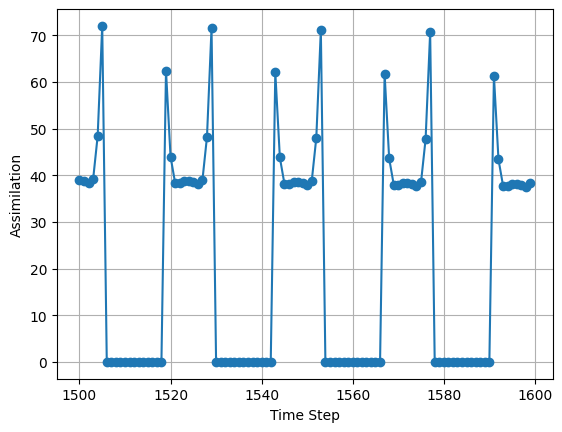

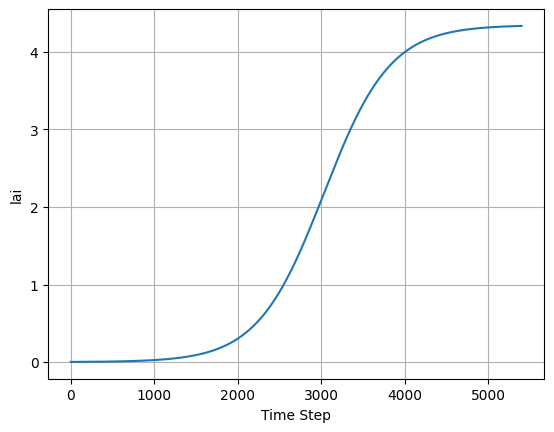

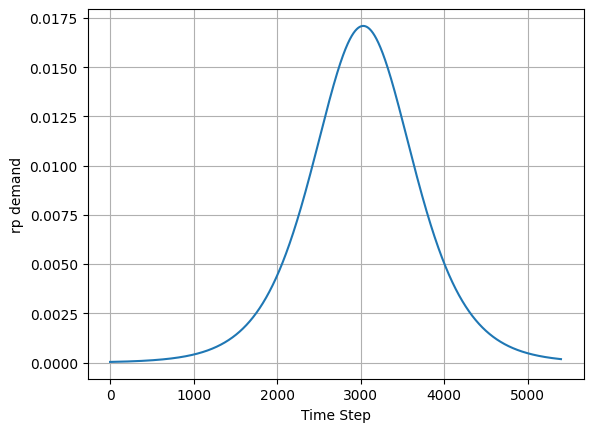

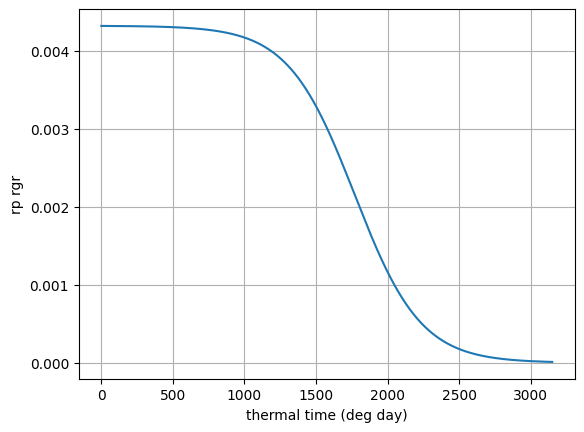

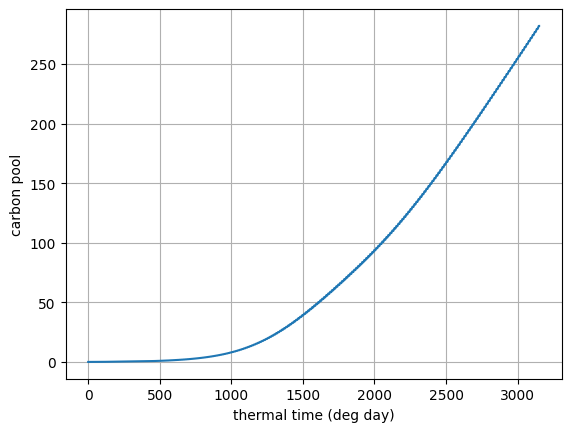

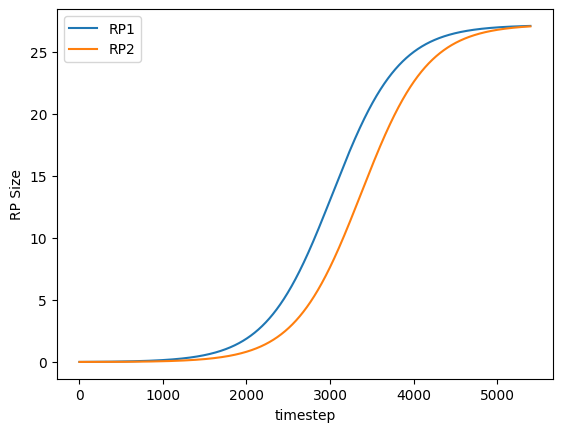

In [207]:
#@title Example simulation
driver_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/drivers_setpoints.csv'
#driver_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/drivers_natural_all.csv'
#driver_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/drivers_radiation_natural_temp_setpoint.csv'
#driver_file = 'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/drivers_radiation_setpoint_natural_temp.csv'

parameter_file =  'https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/parameters.csv'
resource_pool_file ='https://raw.githubusercontent.com/DRWang3/MPM_testing/refs/heads/main/resource_pools_2RPs.csv'

model = ModelHandler(driver_file, parameter_file, resource_pool_file)
model.run_simulation()
model.plot_outputs()